# RNN Model
By Josh Houlding

The aim behind RNN is sequencing data, as well as determining the probability of an occurrence. Some common examples are chat boxes, generating image descriptions, and predicting or forecasting.

Complete the steps below, then write a comprehensive technical report as a Python Jupyter notebook (to include all code, code comments, all outputs, plots, and analysis). Make sure the project documentation contains a) problem statement, b) algorithm of the solution, c) analysis of the findings, and d) references.

# [Assignment Instructions](https://halo.gcu.edu/courses/DSC-550-O500-20240711#assignment-submission/76d47053-c0af-4134-89fe-a82df9884926)

1. Build a long short-term memory (LSTM) model to predict the price of stock for Apple for the year 2021.
2. Use 75 epochs.
3. Visualize the results for the LSTM model.
4. Evaluate your model by determining the root mean squared error and explain your results (how accurate is your model, what could you do to make it better, etc.).
5. See if the model can predict 2022 prices.
6. Summarize the overall functioning of the RNN and its accuracy.

# Task 1
<i>Build a long short-term memory (LSTM) model to predict the price of stock for Apple for the year 2021.</i>

First, we need to find a dataset for Apple's stock prices prior to 2021 that can be used to train a LSTM model.

<b>Potential datasets:</b>
* [Apple Stock Prices (2015-2020) | Kaggle](https://www.kaggle.com/datasets/suyashlakhani/apple-stock-prices-20152020)
* [Apple Stock Prices (1980-2021) | Kaggle](https://www.kaggle.com/datasets/dilaraahan/apple-stock-prices)

<b>Dataset Selected:</b> [Apple Stock Prices (1980-2021) | Kaggle](https://www.kaggle.com/datasets/dilaraahan/apple-stock-prices)

This dataset with data all the way back to 1980 provides us with the most data possible, and the more data we have, the more understanding the model can develop of long-term fluctuations in stock prices.

### Loading the data

In [73]:
import pandas as pd

# Load and view data
df = pd.read_csv("AppleStockPrices.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600,0.0,0.0
1,1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800,0.0,0.0
2,1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000,0.0,0.0
3,1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600,0.0,0.0
4,1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600,0.0,0.0


### Adjusting column names

In [74]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

# Rename "stock splits"
df.rename(columns={"stock splits": "stock_splits"}, inplace=True)

# Show new column names
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stock_splits'],
      dtype='object')

In [75]:
# Create backup of df
df_backup = df

### Exploring the data

In [76]:
# Show dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10274 entries, 0 to 10273
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          10274 non-null  object 
 1   open          10274 non-null  float64
 2   high          10274 non-null  float64
 3   low           10274 non-null  float64
 4   close         10274 non-null  float64
 5   volume        10274 non-null  int64  
 6   dividends     10274 non-null  float64
 7   stock_splits  10274 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 642.3+ KB


In [77]:
# Describe dataset
df.describe().round(2)

,open,high,low,close,volume,dividends,stock_splits
count,10274.00,10274.00,10274.00,10274.00,1.027400e+04,10274.00,10274.00
mean,11.44,11.57,11.32,11.45,3.353372e+08,0.00,0.00
std,24.88,25.16,24.60,24.89,3.404131e+08,0.01,0.09
min,0.04,0.04,0.04,0.04,0.000000e+00,0.00,0.00
25%,0.23,0.24,0.23,0.23,1.272880e+08,0.00,0.00
50%,0.38,0.38,0.37,0.38,2.233728e+08,0.00,0.00
75%,10.92,11.02,10.81,10.91,4.176998e+08,0.00,0.00
max,156.98,157.26,154.39,156.69,7.421641e+09,0.22,7.00


### Preparing the data
To use the `date` column for time series analysis, we need to convert it to datetime format and use it as the dataframe index.

In [78]:
# Convert "date" to datetime
df["date"] = pd.to_datetime(df["date"])

# Set date as index
df.set_index("date", inplace=True)

We should also select the most relevant features for analysis. We will go with `open`, `high`, `low`, `close`, and `volume`, since these are commonly used for stock price prediction.

In [79]:
# Select relevant features
df = df[["open", "high", "low", "close", "volume"]]

#### Removing duplicates and checking for missing values

In [80]:
# Drop duplicates
df = df.drop_duplicates()

# Find missing count by column
missing_count = df.isna().sum()
print(f"Missing values by column: \n {missing_count}")

Missing values by column: 
 open      0
high      0
low       0
close     0
volume    0
dtype: int64


Duplicates and missing values have now been taken care of.

### Creating training data
Now we need to generate the training data for the model. This involves scaling the label `close`, creating sequences and performing a train-test split.

In [81]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Define training period (1980-2020) and test period (2021)
train_start_date = "1980-12-12"
train_end_date = "2020-12-31"
test_start_date = "2021-01-01"
test_end_date = "2021-12-31"

# Filter data for training and testing
train_data = df.loc[train_start_date:train_end_date]
test_data = df.loc[test_start_date:test_end_date]

# Extract and scale label "close" 
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[["close"]])
test_scaled = scaler.transform(test_data[["close"]])

# Set sequence length (number of previous data points the model will use to calculate the next one)
sequence_length = 20

# Create training sequences
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=32)
x_train, y_train = [], []
for i in range(len(train_generator)): 
    x_, y_ = train_generator[i]
    x_train.append(x_)
    y_train.append(y_)

# Convert lists to numpy arrays    
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# Create test sequences
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=sequence_length, batch_size=1)
x_test, y_test = [], []
for i in range(len(test_generator)):
    x_, y_ = test_generator[i]
    x_test.append(x_)
    y_test.append(y_)

x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

x_train shape: (10080, 20, 1), x_test shape: (154, 20, 1)
y_train shape: (10080, 1), y_test shape: (154, 1)


The test data covers about the first 40% of dates in 2021, which should be representative of stock prices in 2021 overall. This is affected by the sequence length chosen, with which I tried to strike a balance between training efficiency, accuracy, and volume of predictions that could be generated.

### Training the LSTM model

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Build LSTM model architecture
model = Sequential()
model.add(Input(shape=(sequence_length, x_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Task 2
<i>Use 75 epochs.</i>

In [83]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define early stopping (training will end when subsequent epochs don't yield substantial improvement)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min", verbose=1)
            
# Train the model
history = model.fit(x_train, y_train, epochs=75, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.6478e-04 - val_loss: 5.2870e-04
Epoch 2/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.4880e-06 - val_loss: 6.3417e-04
Epoch 3/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.3508e-06 - val_loss: 7.0960e-04
Epoch 4/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.1904e-06 - val_loss: 7.5635e-04
Epoch 5/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.2790e-06 - val_loss: 7.5578e-04
Epoch 6/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.1565e-06 - val_loss: 7.0732e-04
Epoch 7/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0241e-06 - val_loss: 6.4656e-04
Epoch 8/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.8652e-06 - val_loss: 5.9942e-04
Epoch 9/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7169e-06 - val_loss: 5.6715e-04
Epoch 10/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.6049e-06 - val_loss: 5.4018e-04
Epoch 11/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0098e-07 - val_loss: 8.3547e-05
Epoch 65/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.9815e-07 - val_loss: 8.3554e-05
Epoch 66/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.9542e-07 - val_loss: 8.3587e-05
Epoch 67/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9279e-07 - val_loss: 8.3643e-05
Epoch 68/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9025e-07 - val_loss: 8.3720e-05
Epoch 69/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8781e-07 - val_loss: 8.3815e-05
Epoch 70/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8545e-07 - val_loss: 8.3925e-05
Epoch 71/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8318e-07 - val_loss: 8.4050e-05
Epoch 72/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8100e-07 - val_loss: 8.4187e-05
Epoch 73/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.7889e-07 - val_loss: 8.4334e-05
Epoch 74/75
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5

In [84]:
# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f"Test loss: {loss}")

# Make predictions
predictions = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6868e-04  
Test loss: 0.001011849963106215
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


# Task 3
<i>Visualize the results for the LSTM model.</i>

There are many ways we can visualize the performance and results of the model, with these being the best choices: 
* <b>Loss curves.</b> These will shine light on how well the model generalizes. If the training and validation loss curves converge, it means the model is highly generalizable, and divergence indicates potential overfitting problems.
* <b>Plot of predicted vs. actual AAPL stock prices.</b> This is a very simple way to gauge how accurate the model's predictions are.

#### Loss curves

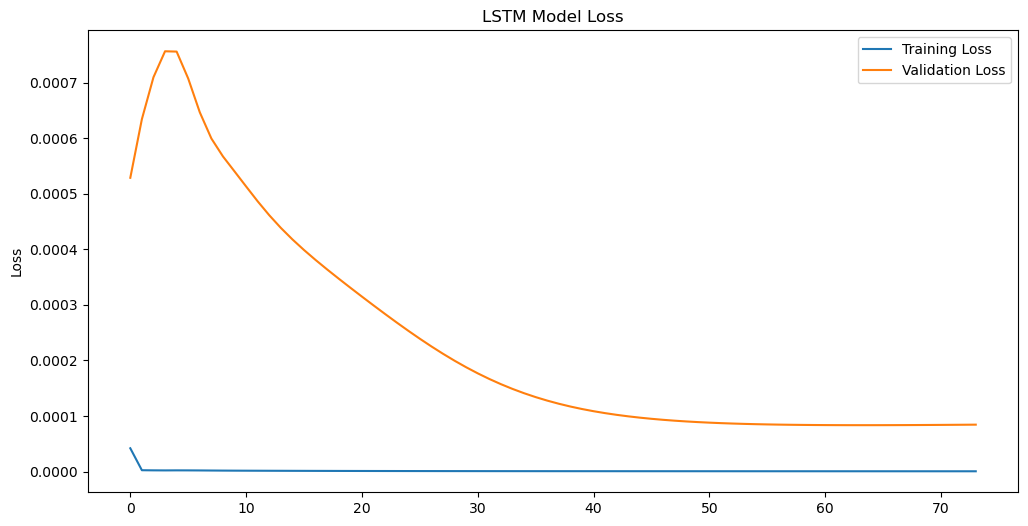

In [85]:
import matplotlib.pyplot as plt

# Plot loss for training and validation sets
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("LSTM Model Loss")
plt.ylabel("Loss")
plt.legend()
plt.show()

We see training loss almost immediately drop to near-zero, while the validation loss starts very low and declines to even lower levels over time. Both of these curves suggest a high level of performance.

#### Predicted vs. actual values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


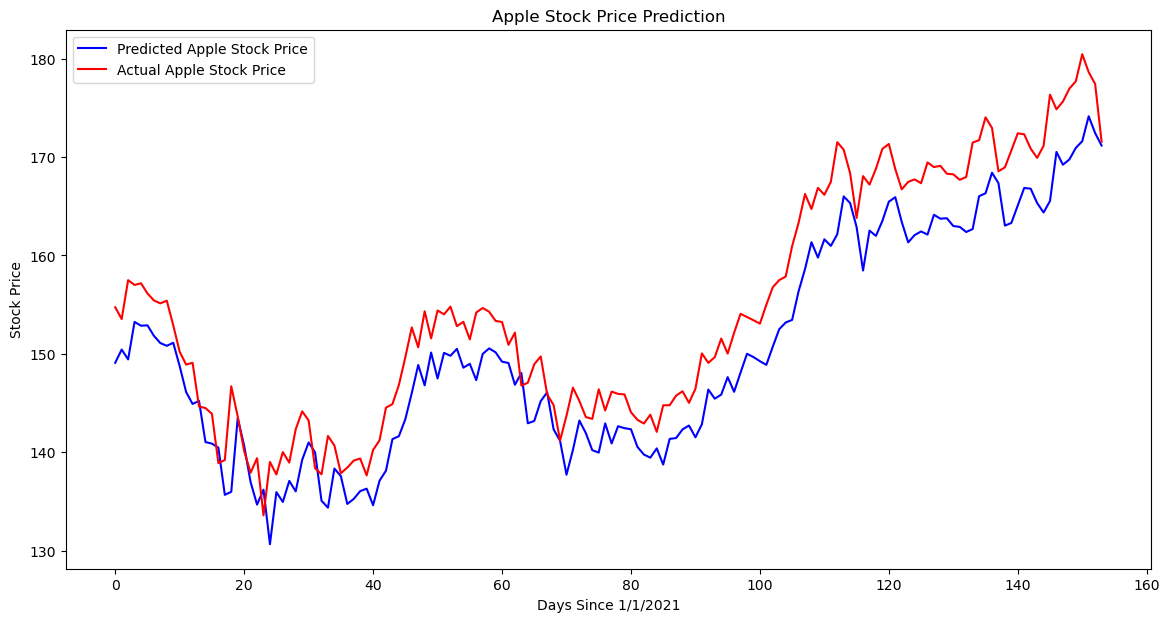

In [86]:
# Extract "close" column from the original data
close_prices = df[["close"]]

# Scale "close" column separately
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(close_prices)

# Make model predictions again
predictions = model.predict(x_test)

# Apply an inverse transformation to predictions and actual values to get actual stock prices
inv_predictions = close_scaler.inverse_transform(predictions)
inv_prices = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs. actual prices
plt.figure(figsize=(14, 7))
plt.plot(inv_predictions, color="blue", label="Predicted Apple Stock Price")
plt.plot(inv_prices, color="red", label="Actual Apple Stock Price")
plt.title("Apple Stock Price Prediction")
plt.xlabel("Days Since 1/1/2021")
plt.ylabel("Stock Price")
#plt.ylim(0, 180)
plt.legend()
plt.show()

The model effectively captures the long-term trends in Apple's stock price, but it consistently underpredicts. This could be because of an inadequate LSTM architecture, issues with data normalization, or an imbalance in the training data.

# Task 4
<i>Evaluate your model by determining the root mean squared error and explain your results (how accurate is your model, what could you do to make it better, etc.).</i>

In [87]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_predictions, inv_prices))
print(f"Model RMSE: {rmse}")

Model RMSE: 4.983022402119684


Let's contextualize this RMSE value by looking at the distribution of closing prices and how they have changed over time.

Descriptive statistics: 
 count    10274.000000
mean        11.447856
std         24.891118
min          0.038490
25%          0.232631
50%          0.378673
75%         10.906268
max        156.690002
Name: close, dtype: float64
Median: 0.37867288291454315


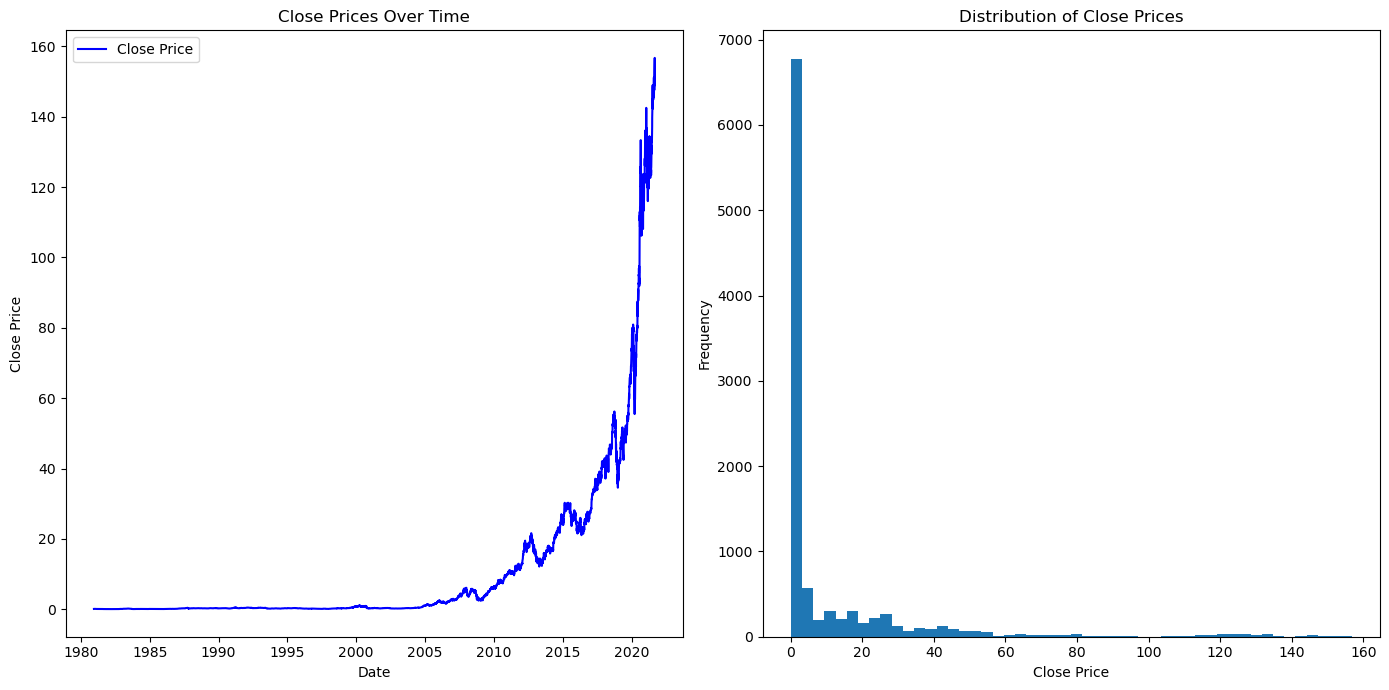

In [88]:
# Load original data
df = df_backup

# Show descriptive statistics for closing price
print("Descriptive statistics: \n", df["close"].describe())
median = df["close"].median()
print(f"Median: {median}")

# Set up plot container
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot line graph of closing prices
axes[0].plot(df["close"], color="blue", label="Close Price")
axes[0].set_title("Close Prices Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Close Price")
axes[0].legend()

# Plot histogram of closing prices
axes[1].hist(df["close"], bins=50)
axes[1].set_title("Distribution of Close Prices")
axes[1].set_xlabel("Close Price")
axes[1].set_ylabel("Frequency")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

The model RMSE is around half of the mean stock price, <span>&dollar;11.45</span>, and extremely high when compared to the median stock price of about <span>&dollar;0.38</span>. This inaccuracy can probably be attributed largely to the systematic underpredictions the model makes.

# Task 5
<i>See if the model can predict 2022 prices.</i>

To do this, we will use a sequence-to-sequence (Seq2Seq) model that iteratively generates predictions for each day of 2022 using the last predicted value as input for the next one.

In [89]:
# Get previous data
prev_sequence = test_scaled[-sequence_length:]
predicted_prices = []

# Make predictions for 2022
for _ in range(365): 
    next_value = model.predict(prev_sequence.reshape(1, sequence_length, 1), verbose=0)
    predicted_prices.append(next_value[0, 0])
    prev_sequence = np.append(prev_sequence[1:], next_value, axis=0)

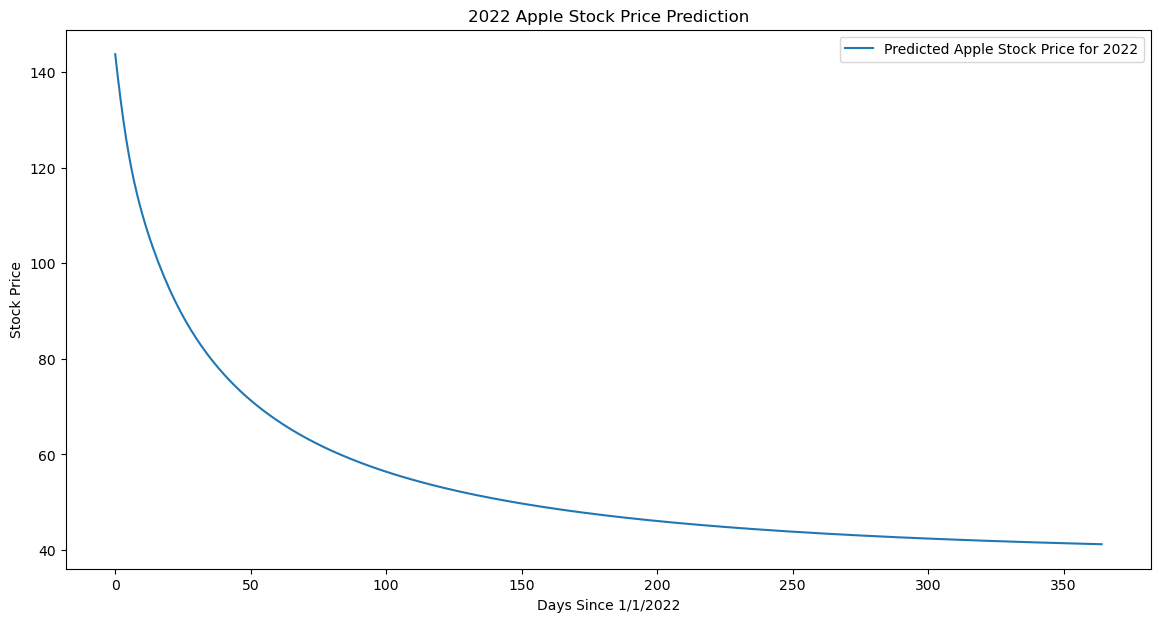

In [90]:
# Apply inverse transformation to predictions to get actual prices
inv_predictions_2022 = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Plot predictions
plt.figure(figsize=(14, 7))
plt.plot(inv_predictions_2022, label="Predicted Apple Stock Price for 2022")
plt.title("2022 Apple Stock Price Prediction")
plt.xlabel("Days Since 1/1/2022")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

The predictions the model made for 2022 stock prices do not look reflective of reality at all, showing an exponential decay. This indicates a problem with how these prices are calculated. One potential solution would be to retrain the entire model using 1980-2021 as the training set and then make 2022 predictions based on that, but this would be expensive in terms of development time and effort as well as computational cost.

# Task 6
<i>Summarize the overall functioning of the RNN and its accuracy.</i>

Overall, the RNN did a decent job of predicting Apple's 2021 stock prices. It captured both short-term and long-term trends with a high degree of detail, but systematically struggled with underpredicting prices. Additionally, predicting prices for 2022 turned out to be a challenge, likely because of model drift, which is when small errors accumulate and lead to significant divergence from realistic values.

To remedy the problems with this model in the future, we could try different model architectures, modify the normalization/scaling process, and experiment with regularization methods to prevent overfitting.

# References
Awan, A. A. (2022, March 16). Recurrent neural network tutorial (RNN). DataCamp. https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network <br>
OpenAI. (2024). ChatGPT [Large language model]. https://chatgpt.com/ <br>
Microsoft. (2024). Copilot [Large language model]. https://www.bing.com/?FORM=Z9FD1